## 1. 流匹配 Flow Matching

通过直接匹配一个源分布到数据分布的连续变换路径的学习方法。

[Flow Matching 论文](https://arxiv.org/pdf/2210.02747)

In [2]:
from IPython.display import Image, display
url = 'https://github.com/facebookresearch/flow_matching/blob/main/assets/teaser.png?raw=true'
display(Image(url=url, width=800))

## 2. 数学表达

在这份指南中，提供了详尽的解答。[Flow Matching Guide and Code](https://arxiv.org/pdf/2412.06264)

Flow Matching 目标是通过连续时间动态系统（常微分方程，ODE）建模数据分布演化，直接学习一个向量场（vector field），使得从噪声分布（如高斯分布）出发沿该向量场积分得到的流（flow）能够匹配目标数据分布。其核心数学工具是最优传输理论（OT）和概率路径的连续归一化流（CNF）

$t=0$ 时刻的状态 $x_0$ 服从初始分布 $p_0$

$t=1$ 时刻的状态 $x_1$ 服从数据分布 $p_1$

中间任意 $t$ 时刻的状态，$x_t$ 满足某个光滑函数 $\phi_t(x)$，最简单的如线性插值， $\phi_t(x)=x_t = (1-t)x_0 + tx_1$

则向量场生成的轨迹可以由ODE描述， $$\frac{d}{dt}\phi_t(x)=u_t(\phi_t(x)),\phi_0(x)=x_0\sim p_0$$

在整个演化过程中，概率密度 $p_t(x)$ 必须满足连续性方程（质量守恒），这是个PDE方程：$$\frac{d}{dt}p_t(x)+\nabla\cdot(p_t(x)u_t(x))=0$$

在线性插值中，有 $\frac{d}{dt}x_t = x_1-x_0$

也就是模型所需要学习的目标。模型的输入是 $x_t$ 和 $t$，其中，$t\sim U(0,1)$

即学习一个参数化的向量场 $u_t(x;\theta)\rightarrow u_t(x)$

有损失函数： $$\mathcal{L}_{FM}(\theta)=\mathbb{E}_{t\sim U(0,1),x\sim p_t(x)}||u_t(x;\theta)-u_t(x)||^2$$

但在一般情况下，由于 $u_t(x)$ 未知，但有 $z\sim p_1$ 是目标分布中的样本，引入条件概率路径 $$p(x|z) \ s.t.\  p_0(x|z)=p_0(x), p_1(x|z)=\delta(x-z)$$

损失函数为：$$\mathcal{L}_{CFM}(\theta)=\mathbb{E}_{t\sim U(0,1),z\sim p_1,x\sim p_t(x|z)}||u_t(x;\theta)-u_t(x|z)||^2$$

---

**要点1：概率路径是提前设计的**

线性插值当然是最简单，也可以有非线性路径，如另外一个神经网络。

在黎曼流形上，则可引入测地线，作为最短路径。

此外，还有一个思路是引入与时间相关的方差调度，控制路径扩散。导则指引P30。

**要点2：条件信息引注入**

如分类标签、文本描述、多模态等条件融合，编入条件路径。

**要点3：向量场设计**

也就是模型设计。（1）时间嵌入；（2）条件信息嵌入；（3）目标向量场推导；（4）损失函数。

其中，目标向量场取决于路径设计，在线性插值中，目标向量场为：$$u_t(x|z)=\frac{z-x_0}{1-t}$$

对应的损失函数是：$$\mathcal{L}_{CFM}(\theta)=\mathbb{E}_{t,z,x_0} \left\| u_t(\phi_t(x_0);\theta)-\frac{z-x_0}{1-t}\right\| ^2$$

## 3. 简单实现

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.amp import autocast, GradScaler
from torchinfo import summary
import math
import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset
import torchvision.utils as vutils
import tqdm

In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = 'data/MNIST/'
image_size = 28
batch_size = 128
channels = 1

In [101]:
mean=[0.1307]
std=[0.3081]
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, -1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, -1, 1, 1).to(tensor.device)
    return tensor * std + mean

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [102]:
dataset = datasets.MNIST(root='./data/', transform=transform, download='True', train=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

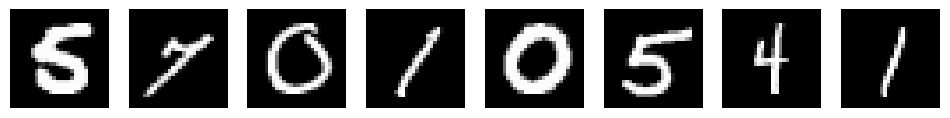

In [103]:
images, _ = next(iter(dataloader))  # images: [B, 1, 28, 28]
images = denormalize(images[:8], mean=[0.1307], std=[0.3081])
# 去通道维度并绘图
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(images[i].squeeze(0).cpu(), cmap="gray")
    axes[i].axis("off")
plt.show()

In [199]:
# Time embedding
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim * 4)
        self.linear2 = nn.Linear(dim * 4, dim)
        self.act = nn.SiLU()

    def forward(self, t):
        half_dim = self.linear1.in_features // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return self.linear2(self.act(self.linear1(emb)))

In [200]:
# Residual block with time embedding
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_ch)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
        self.residual = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        h = h + self.time_mlp(t_emb).squeeze(1)[:,:,None,None]
        h = self.block2(h)
        return h + self.residual(x)

In [201]:
# Self-Attention block (for 2D images)
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv1d(channels, channels, 1)
        self.k = nn.Conv1d(channels, channels, 1)
        self.v = nn.Conv1d(channels, channels, 1)
        self.proj = nn.Conv1d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        x_ = self.norm(x).view(B, C, H * W)  # [B, C, HW]
        q, k, v = self.q(x_), self.k(x_), self.v(x_)

        attn = torch.softmax(q.transpose(1, 2) @ k / math.sqrt(C), dim=-1)
        out = v @ attn.transpose(1, 2)  # [B, C, HW]
        out = self.proj(out).view(B, C, H, W)
        return out + x

In [202]:
# UNet with Conv down/up and center attention
class UNet(nn.Module):
    def __init__(self, time_emb_dim=128):
        super().__init__()
        self.time_embedding = TimeEmbedding(time_emb_dim)

        self.enc1 = ResBlock(32, 32, time_emb_dim)
        self.down1 = nn.Conv2d(32, 64, 4, 2, 1)  # downsample
        self.enc2 = ResBlock(64, 64, time_emb_dim)

        self.mid = nn.Sequential(
            ResBlock(64, 64, time_emb_dim),
            AttentionBlock(64),
            ResBlock(64, 64, time_emb_dim)
        )

        self.up1 = nn.ConvTranspose2d(64, 32, 4, 2, 1)  # upsample
        self.dec1 = ResBlock(32, 32, time_emb_dim)
        self.out = nn.Conv2d(32, 32, 1)

    def forward(self, x, t):
        t_emb = self.time_embedding(t)

        x1 = self.enc1(x, t_emb)
        x2 = self.enc2(self.down1(x1), t_emb)
        
        # 修改点：传递 t_emb 给 mid
        x_mid = self.mid[0](x2, t_emb)  # ResBlock
        x_mid = self.mid[1](x_mid)      # AttentionBlock
        x_mid = self.mid[2](x_mid, t_emb)  # ResBlock

        x_up = self.dec1(self.up1(x_mid), t_emb)
        return self.out(x_up)

In [241]:
learning_rate = 1e-4
epochs = 40

In [242]:
# 初始化模型，并转到对应设备
model = UNet().to(device)

# 定义优化器与损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [243]:
summary(model, input_size=[(1,32,32,32),(1,)])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [128, 1, 28, 28]          --
├─TimeEmbedding: 1-1                     [1, 128]                  --
│    └─Linear: 2-1                       [1, 512]                  66,048
│    └─SiLU: 2-2                         [1, 512]                  --
│    └─Linear: 2-3                       [1, 128]                  65,664
├─ResBlock: 1-2                          [128, 32, 28, 28]         --
│    └─Sequential: 2-4                   [128, 32, 28, 28]         --
│    │    └─Conv2d: 3-1                  [128, 32, 28, 28]         320
│    │    └─GroupNorm: 3-2               [128, 32, 28, 28]         64
│    │    └─SiLU: 3-3                    [128, 32, 28, 28]         --
│    └─Sequential: 2-5                   [1, 32]                   --
│    │    └─SiLU: 3-4                    [1, 128]                  --
│    │    └─Linear: 3-5                  [1, 32]                   4,128
│  

In [244]:
# 可视化保存路径
def save_samples(samples, step, path="./images/FM/"):
    os.makedirs(path, exist_ok=True)
    save_image(samples, os.path.join(path, f"{step:04d}.png"), nrow=8, normalize=True)

Epoch 0: 100%|████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.35it/s, loss=0.46]


[Epoch 0] Loss: 0.6385


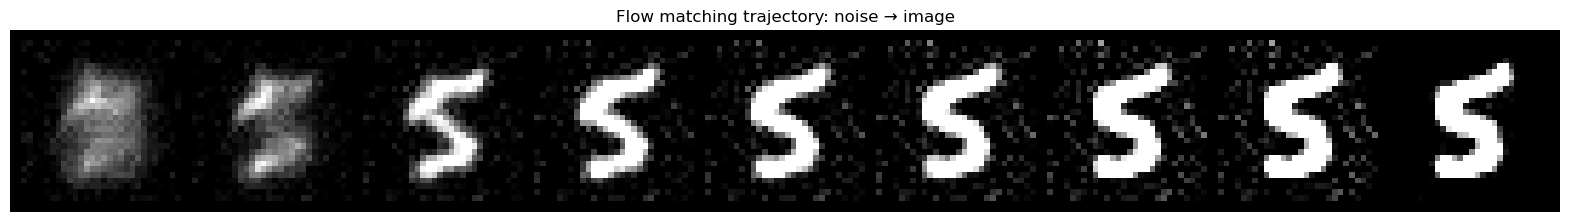

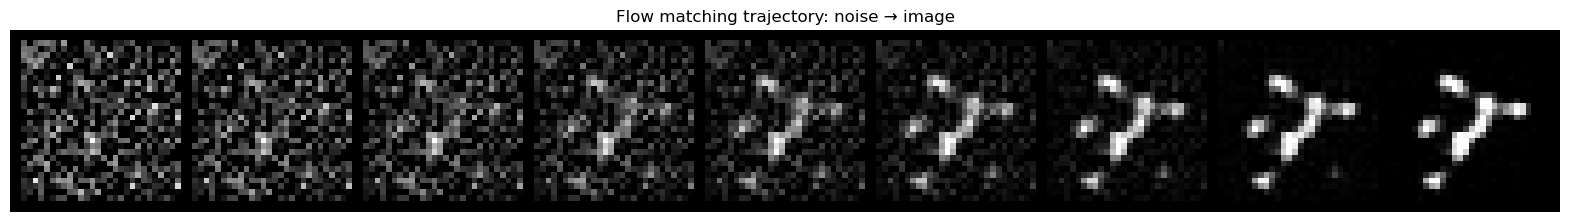

Epoch 1: 100%|███████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.80it/s, loss=0.392]


[Epoch 1] Loss: 0.4385


Epoch 2: 100%|███████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.61it/s, loss=0.356]


[Epoch 2] Loss: 0.3982


Epoch 3: 100%|███████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.72it/s, loss=0.354]


[Epoch 3] Loss: 0.3780


Epoch 4: 100%|████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.58it/s, loss=0.34]


[Epoch 4] Loss: 0.3665


Epoch 5: 100%|████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.31it/s, loss=0.31]


[Epoch 5] Loss: 0.3592


Epoch 6: 100%|███████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.98it/s, loss=0.362]


[Epoch 6] Loss: 0.3531


Epoch 7: 100%|███████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.44it/s, loss=0.321]


[Epoch 7] Loss: 0.3473


Epoch 8: 100%|███████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 16.08it/s, loss=0.349]


[Epoch 8] Loss: 0.3435


Epoch 9: 100%|████████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.65it/s, loss=0.32]


[Epoch 9] Loss: 0.3401


Epoch 10: 100%|██████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.82it/s, loss=0.388]


[Epoch 10] Loss: 0.3385


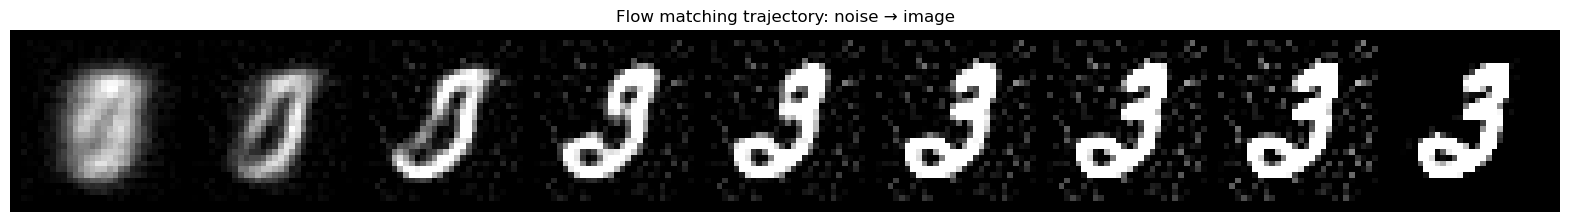

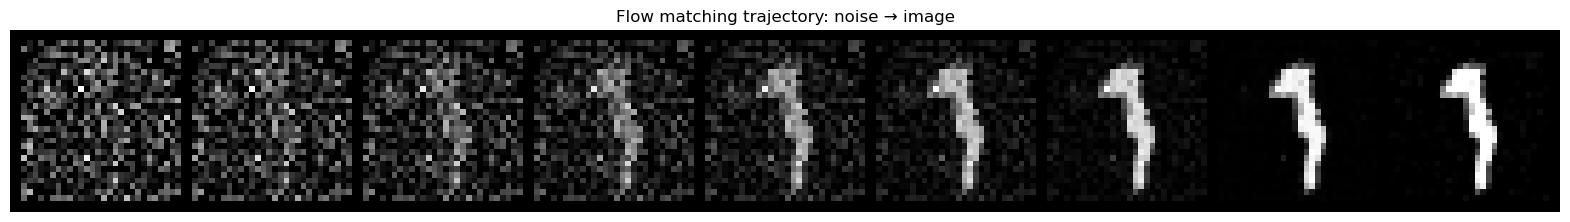

Epoch 11: 100%|██████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.80it/s, loss=0.357]


[Epoch 11] Loss: 0.3338


Epoch 12: 100%|██████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.75it/s, loss=0.264]


[Epoch 12] Loss: 0.3316


Epoch 13: 100%|██████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.79it/s, loss=0.347]


[Epoch 13] Loss: 0.3295


Epoch 14: 100%|██████████████████████████████████████████████████████████| 469/469 [00:30<00:00, 15.45it/s, loss=0.291]


[Epoch 14] Loss: 0.3288


Epoch 15: 100%|██████████████████████████████████████████████████████████| 469/469 [00:30<00:00, 15.29it/s, loss=0.323]


[Epoch 15] Loss: 0.3276


Epoch 16: 100%|██████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.94it/s, loss=0.302]


[Epoch 16] Loss: 0.3248


Epoch 17: 100%|██████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.77it/s, loss=0.341]


[Epoch 17] Loss: 0.3250


Epoch 18: 100%|██████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.66it/s, loss=0.364]


[Epoch 18] Loss: 0.3229


Epoch 19: 100%|██████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.72it/s, loss=0.302]


[Epoch 19] Loss: 0.3221


Epoch 20: 100%|███████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.62it/s, loss=0.34]


[Epoch 20] Loss: 0.3212


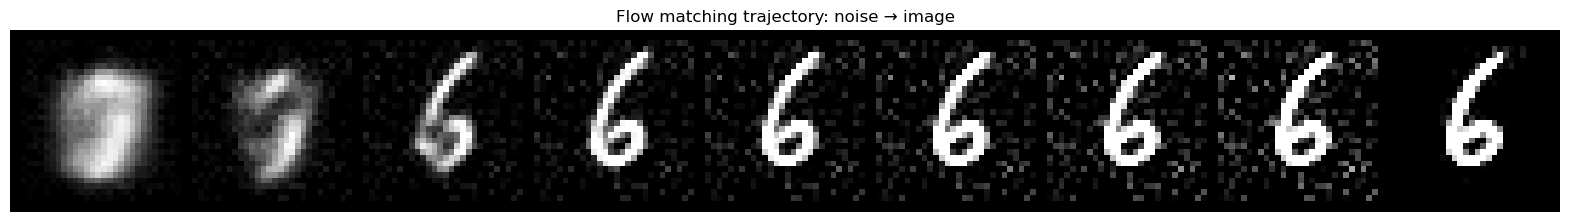

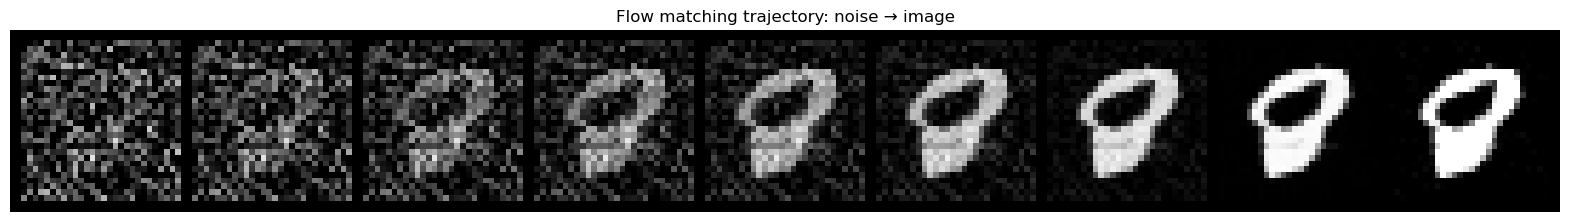

Epoch 21: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.32it/s, loss=0.302]


[Epoch 21] Loss: 0.3186


Epoch 22: 100%|██████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.67it/s, loss=0.319]


[Epoch 22] Loss: 0.3185


Epoch 23: 100%|███████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.90it/s, loss=0.32]


[Epoch 23] Loss: 0.3177


Epoch 24: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.27it/s, loss=0.307]


[Epoch 24] Loss: 0.3158


Epoch 25: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.62it/s, loss=0.341]


[Epoch 25] Loss: 0.3160


Epoch 26: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.70it/s, loss=0.294]


[Epoch 26] Loss: 0.3155


Epoch 27: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.66it/s, loss=0.321]


[Epoch 27] Loss: 0.3152


Epoch 28: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.25it/s, loss=0.341]


[Epoch 28] Loss: 0.3142


Epoch 29: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.25it/s, loss=0.282]


[Epoch 29] Loss: 0.3129


Epoch 30: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.27it/s, loss=0.292]


[Epoch 30] Loss: 0.3136


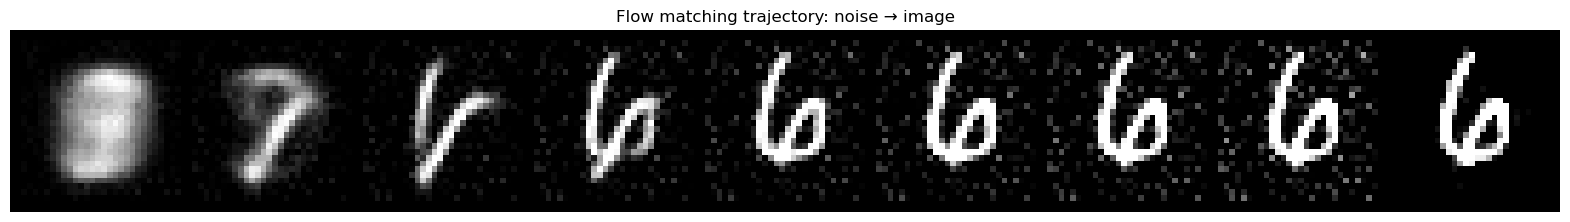

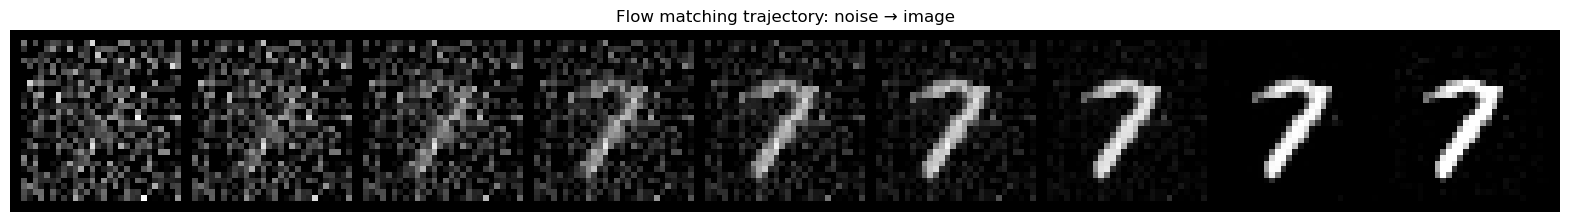

Epoch 31: 100%|██████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.98it/s, loss=0.291]


[Epoch 31] Loss: 0.3124


Epoch 32: 100%|██████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.87it/s, loss=0.298]


[Epoch 32] Loss: 0.3145


Epoch 33: 100%|██████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.83it/s, loss=0.303]


[Epoch 33] Loss: 0.3140


Epoch 34: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.69it/s, loss=0.346]


[Epoch 34] Loss: 0.3110


Epoch 35: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.72it/s, loss=0.337]


[Epoch 35] Loss: 0.3117


Epoch 36: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.71it/s, loss=0.287]


[Epoch 36] Loss: 0.3113


Epoch 37: 100%|███████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.55it/s, loss=0.31]


[Epoch 37] Loss: 0.3115


Epoch 38: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.64it/s, loss=0.329]


[Epoch 38] Loss: 0.3112


Epoch 39: 100%|██████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.47it/s, loss=0.298]

[Epoch 39] Loss: 0.3120


In [245]:
for epoch in range(epochs):
    model.train()
    pbar = tqdm.tqdm(dataloader, desc=f"Epoch {epoch}")
    total_loss = 0
    for batch_idx, (x, _) in enumerate(pbar):
        x = x.to(device)
        batch_size = x.size(0)
        
        z = torch.randn_like(x).to(device)
        t = torch.rand(batch_size, 1).to(device)
        t_expanded  = t.unsqueeze(2).unsqueeze(3)
        xt = (1-t_expanded)*z + t_expanded*x
        target_v = x - z
        pred_v = model(xt, t)
        
        loss = criterion(pred_v, target_v)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()        
        pbar.set_postfix(loss=loss.item())

        # 打印训练过程中的信息

    scheduler.step()  # 更新学习率
    avg_loss = total_loss / len(dataloader)
    print(f"[Epoch {epoch}] Loss: {avg_loss:.4f}")

    if epoch % 10 == 0:
        sample = next(iter(dataloader))
        x_sample = sample[0][0:1]  # 取一个样本
        z_sample = torch.randn_like(x_sample)
        visualize_prediction(model, x_sample, z_sample, steps=8)
        visualize_from_noise(model, steps=8)

In [238]:
@torch.no_grad()
def visualize_prediction(model, x, z, steps=8):
    """
    显示给定时间 t 下，模型预测出的 vector field 效果
    x: 真实图像 [1, 1, 28, 28]
    z: 噪声图像 [1, 1, 28, 28]
    t_val: 时间步 t ∈ [0, 1]
    """
    model.eval()
    x = x.to(device)
    z = z.to(device)
    images = []
    for i in range(steps+1):
        t_val = i / steps
            
        t_img = torch.tensor([[t_val]], device=device)
        t = t_img.view(-1, 1, 1, 1)
        
        # 构造 x_t 和目标 vector
        x_t = (1 - t) * z + t * x
        pred_v = model(x_t, t_img)
    
        # 还原图像（用 x_t + v 还原出 x0 近似图）
        x_hat = x_t + pred_v
        x_hat = denormalize(x_hat, mean, std)
        
        images.append(x_hat[0].clamp(0, 1))


    grid = vutils.make_grid(images, nrow=steps+1, normalize=True, scale_each=True)
    
    plt.figure(figsize=(20, 4))
    plt.title(f"Flow matching trajectory: noise → image")
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

In [239]:
@torch.no_grad()
def visualize_from_noise(model, steps=8):
    """
    从随机噪声出发，通过 flow 模型生成图像的逐步演变过程
    """
    model.eval()
    z = torch.randn(1, 1, 28, 28).to(device)
    images = []
    x_t = z
    for i in range(steps+1):
        t_val = i / steps
        t_img = torch.tensor([[t_val]], device=device)
        t = t_img.view(-1, 1, 1, 1)
        pred_v = model(x_t, t_img)
        x_t = x_t + (1.0 / steps) * pred_v  # Euler integration
        x_hat = denormalize(x_t, mean, std)
        images.append(x_hat[0].clamp(0, 1))

    grid = vutils.make_grid(images, nrow=steps+1, normalize=False)
    # vutils.save_image(grid, "samples/from_noise_trajectory.png")
    plt.figure(figsize=(20, 4))
    plt.title(f"Flow matching trajectory: noise → image")
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

In [230]:
@torch.no_grad()
def visualize_interpolation(x, z, steps=8):
    """
    展示从纯噪声到真实图像的插值过程。
    x0: 真实图像，形状 [1, 3, 256, 256]
    z: 噪声图像，形状 [1, 3, 256, 256]
    steps: 插值步数
    """
    x = x.to(device)
    z = z.to(device)
    imgs = []
    for i in range(steps + 1):
        t = i / steps
        xt = (1 - t) * z + t * x
        xt = denormalize(xt, mean, std)
        imgs.append(xt.squeeze(0).cpu())
    
    # 将一组图片拼接显示
    grid = vutils.make_grid(imgs, nrow=steps + 1, normalize=True, scale_each=True)
    plt.figure(figsize=(20, 4))
    plt.title("Interpolation from noise to real image")
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.show()

torch.Size([1, 1, 28, 28])


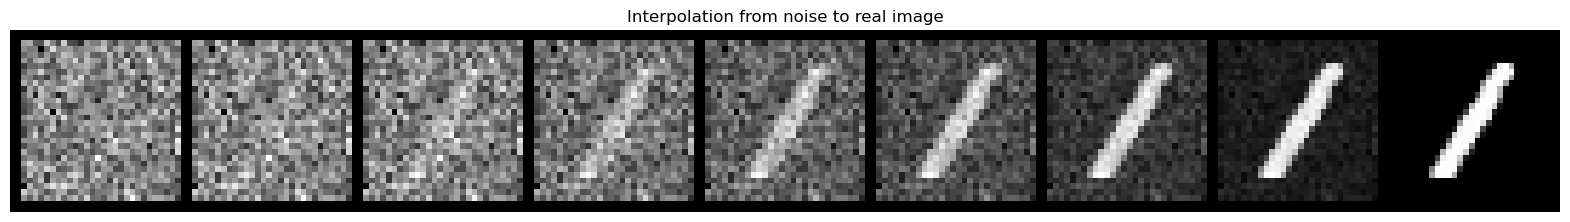

In [231]:
# 假设你的 dataloader 有内容：
sample = next(iter(dataloader))
x_sample = sample[0][0:1]  # 取一个样本
print(x_sample.shape)
z_sample = torch.randn_like(x_sample)

# 插值过程可视化
visualize_interpolation(x_sample, z_sample, steps=8)

In [ ]:
# 模型预测效果对比（在训练前和训练后都可以试试看）
visualize_prediction(model, x_sample, z_sample, t_val=0.5)

In [ ]:
if epoch % 10 == 0:
    visualize_prediction(model, x_sample, z_sample, t_val=0.5)